In [0]:
!python mlip_setup_env.py
!pip install webdavclient3

In [2]:
cd code/hw1/

/content/code/hw1


In [0]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Conv2D, Flatten
from tensorflow.keras.layers import MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import SGD

from starter_eda_model_funcs import MultiOutputDataGenerator, get_model
from helper import to_one_hot, preview_data_aug
from preprocessing import perform_preprocessing
from flow import generators_from_prep, generator_wrapper, train
from flow import get_lr_test_scheduler, get_pyramid_lr

# further settings
FIG_DIR = 'results/generated_figs/'
plt.rcParams["figure.figsize"] = (10, 4.5) # set higher on 4k monitor
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["savefig.bbox"] = 'tight'

In [0]:
from webdav3.client import Client

options = {
 'webdav_hostname': "https://joeranbosma.stackstorage.com/remote.php/webdav",
 'webdav_login':    "",
 'webdav_password':  ""
}
client = Client(options)

# Cyclical Learning Rate

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

roi_size = 64
pad_size = 5
cross_val_parts = 8 # for 12.5% validation data and 87.5% train data
cross_val_num = 0 # which part (shuffled) from [0, ..., n-1]

preprocess_args = dict(
    image_width=roi_size + pad_size*2,
    image_height=roi_size + pad_size*2,
    padding=pad_size,
    cross_val_num=cross_val_num,
    cross_val_parts=cross_val_parts,
)

data_path = 'Data/'
prep_path = f"Data/prep/prep_{roi_size}_{pad_size}/"

## Learning rate test 
Increase the learning rate from 0 to 2 in 20 epochs. This gives a slope of ~0.1 per epoch.  
See result: https://app.wandb.ai/joeranbosma/mlip/runs/tkcpti80?workspace=user-joeranbosma

In [0]:
name      = f"orignet-clr-test-2_0"
model_path = f'Model/{name}/'
external_path = f'models/{name}/'
lr_scheduler = get_lr_test_scheduler(lr_start=0.001, lr_end=2.0, num=20)

# Model from Starter EDA kernel, but with SGD instead of Adam
model = get_model(img_size=74, optimizer = "SGD")

Start training of orignet-clr-test-2_0...
['loss', 'out_root_loss', 'out_vowel_loss', 'out_consonant_loss', 'out_root_acc', 'out_vowel_acc', 'out_consonant_acc']
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


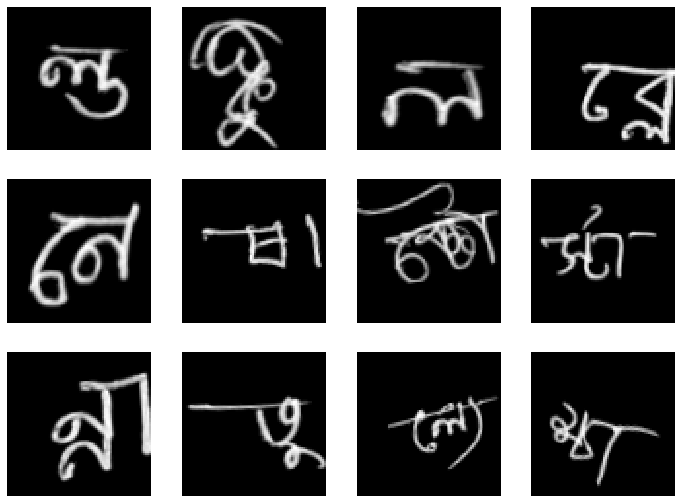

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 686 steps, validate for 98 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
685/686 [============================>.] - ETA: 0s - loss: 3.4628 - out_root_loss: 5.1062 - out_vowel_loss: 2.2854 - out_consonant_loss: 1.3534 - out_root_acc: 0.0195 - out_vowel_acc: 0.1895 - out_consonant_acc: 0.5857WARNING:tensorflow:sample_weight modes were coerced from
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
686/686 [==============================] - 534s 778ms/step - loss: 3.4625 - out_root_loss: 5.1060 - out_vowel_loss: 2.2851 - out_consonant_loss: 1.3531 - out_root_acc: 0.0195 - out_vowel_acc: 0.1895 - out_consonant_acc: 0.5857 - val_loss: 3.2245 - val_out_root_loss: 4.8397 - val_out_vowel_loss: 2.0139 - val_out_con

In [0]:
# train model
print(f"Start training of {name}...")
model = train(name = name, prep_path=prep_path, data_path=data_path,
                model_path=model_path, datagen_args = datagen_args,
                preprocess_args = preprocess_args, cross_val_parts = cross_val_parts,
                cross_val_num = cross_val_num, epochs=20, lr_scheduler_func=lr_scheduler, 
                webdav_client=client, min_epoch_upload=1, model=model,
                external_path=external_path)

## Add momentum of 0.75
See result: https://app.wandb.ai/joeranbosma/mlip/runs/63kk6dfd?workspace=user-joeranbosma

In [0]:
from tensorflow.keras.optimizers import SGD

name      = f"orignet-clr-test-2_0-momentum"
model_path = f'Model/{name}/'
external_path = f'models/{name}/'
lr_scheduler = get_lr_test_scheduler(lr_start=0.001, lr_end=2.0, num=20)

optimizer = SGD(momentum=0.75)
model = get_model(img_size=74, optimizer=optimizer)

Start training of orignet-clr-test-2_0-momentum...
['loss', 'out_root_loss', 'out_vowel_loss', 'out_consonant_loss', 'out_root_acc', 'out_vowel_acc', 'out_consonant_acc']
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


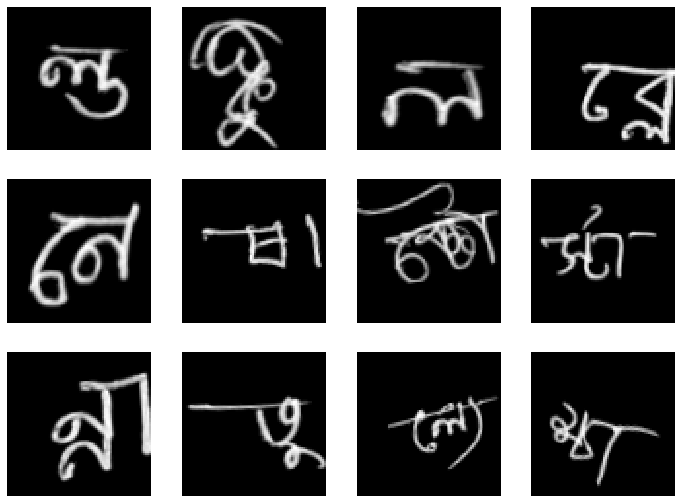

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 686 steps, validate for 98 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
685/686 [============================>.] - ETA: 0s - loss: 3.1933 - out_root_loss: 4.8930 - out_vowel_loss: 1.7742 - out_consonant_loss: 1.2130 - out_root_acc: 0.0289 - out_vowel_acc: 0.3845 - out_consonant_acc: 0.6066WARNING:tensorflow:sample_weight modes were coerced from
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
686/686 [==============================] - 531s 774ms/step - loss: 3.1930 - out_root_loss: 4.8928 - out_vowel_loss: 1.7736 - out_consonant_loss: 1.2127 - out_root_acc: 0.0289 - out_vowel_acc: 0.3846 - out_consonant_acc: 0.6066 - val_loss: 2.9213 - val_out_root_loss: 4.6702 - val_out_vowel_loss: 1.3197 - val_out_con

In [0]:
# train model
print(f"Start training of {name}...")
model = train(name = name, prep_path=prep_path, data_path=data_path,
                model_path=model_path, datagen_args = datagen_args,
                preprocess_args = preprocess_args, cross_val_parts = cross_val_parts,
                cross_val_num = cross_val_num, epochs=20, lr_scheduler_func=lr_scheduler, 
                webdav_client=client, min_epoch_upload=1, model=model,
                external_path=external_path)

## Change momentum cyclical
And use Nesterov.  

In [0]:
from tensorflow.keras.optimizers import SGD

name      = f"orignet-clr-test-2_0-momentum"
model_path = f'Model/{name}/'
external_path = f'models/{name}/'
lr_scheduler = get_lr_test_scheduler(lr_start=0.001, lr_end=2.0, num=20)

optimizer = SGD(momentum=0.75, nesterov=True)
model = get_model(img_size=74, optimizer=optimizer)

1

...implementation...

## Employ CLR
From the run with momentum followed that the training broke down near a learning rate of 1.4 in 14 epochs, see [here](https://app.wandb.ai/joeranbosma/mlip/runs/63kk6dfd?workspace=user-joeranbosma). Based on that, the run below increases the learning rate until 1.2 (to be a bit safer), with the same slope, so in 12 epochs (kind of the minimum I guess). To do this, the a pyramid learning rate scheduler is employed with 12+12+6 epochs = 30.  

Result: https://app.wandb.ai/joeranbosma/mlip/runs/qfxkomde

In [0]:
epochs = 30

name      = f"orignet-clr-1_2-momentum-0_75"
model_path = f'Model/{name}/'
external_path = f'models/{name}/'
lr_scheduler = get_pyramid_lr(lr_start=0.1, lr_max=1.2, n_epoch=epochs, n_epochs_end=6)

optimizer = SGD(momentum=0.75, nesterov=True)
model = get_model(img_size=74, optimizer=optimizer)

Start training of orignet-clr-1_2-momentum-0_75...
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


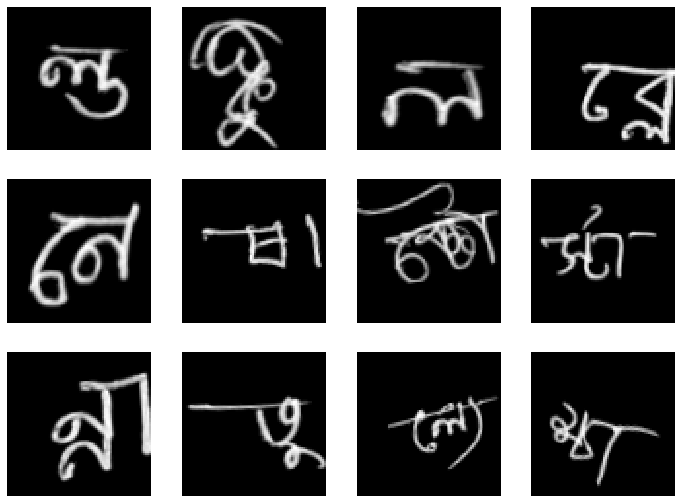

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 686 steps, validate for 98 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
685/686 [============================>.] - ETA: 0s - loss: 2.6244 - out_root_loss: 4.1495 - out_vowel_loss: 1.2365 - out_consonant_loss: 0.9620 - out_root_acc: 0.0747 - out_vowel_acc: 0.5449 - out_consonant_acc: 0.6569WARNING:tensorflow:sample_weight modes were coerced from
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
686/686 [==============================] - 555s 810ms/step - loss: 2.6236 - out_root_loss: 4.1486 - out_vowel_loss: 1.2358 - out_consonant_loss: 0.9613 - out_root_acc: 0.0747 - out_vowel_acc: 0.5450 - out_consonant_acc: 0.6570 - val_loss: 3.0479 - val_out_root_loss: 5.0572 - val_out_vowel_loss: 1.0716 - val_out_conso

KeyboardInterrupt: ignored

404 response executing GraphQL.
{"errors":[{"message":"run joeranbosma/mlip/nkh4tccp not found during upsertBucket","path":["upsertBucket"]}],"data":{"upsertBucket":null}}
wandb: ERROR Error while calling W&B API: run joeranbosma/mlip/nkh4tccp not found during upsertBucket (<Response [404]>)


Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f453d9dea60> (for post_run_cell):


CommError: ignored

In [13]:
# train model
print(f"Start training of {name}...")
model = train(name = name, prep_path=prep_path, data_path=data_path,
                model_path=model_path, datagen_args = datagen_args,
                preprocess_args = preprocess_args, cross_val_parts = cross_val_parts,
                cross_val_num = cross_val_num, epochs=epochs, lr_scheduler_func=lr_scheduler, 
                webdav_client=client, min_epoch_upload=1, model=model,
                external_path=external_path)